# Customer Clustering
https://www.kaggle.com/datasets/dev0914sharma/customer-clustering

The dataset consists of information about the purchasing behavior of 2,000 individuals from a given area when entering a physical ‘FMCG’ store. All data has been collected through the loyalty cards they use at checkout. The data has been preprocessed and there are no missing values. In addition, the volume of the dataset has been restricted and anonymised to protect the privacy of the customers.

In [ ]:
!pip install kagglehub
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=f714498777cdf975672509a147f431a9660aef3287cc7dbf5cd1fda0bc49805a
  Stored in directory: /root/.cache/pip/wheels/96/98/a5/52dee3e8ed1dbfc4d77e4da41b6d89dd7ab9ead1b921e766f8
Successfully built minisom


In [ ]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn import datasets
from yellowbrick.cluster import SilhouetteVisualizer

In [ ]:
# Download latest version
path = kagglehub.dataset_download("dev0914sharma/customer-clustering")

print("Path to dataset files:", path)
data_file = os.path.join(path, 'segmentation data.csv')
df = pd.read_csv(data_file)
df.info()

Path to dataset files: /root/.cache/kagglehub/datasets/dev0914sharma/customer-clustering/versions/1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


**ID** (Numerical Integer) - Shows a unique identificator of a customer.

**Sex** (Categorical {0 male, 1 female}) - Biological sex (gender) of a customer. In this dataset there are only 2 different options.

**Marital status** (Categorical {0 single, 1 non-single}) - Martial status of a customer.

**Age** (Numerical Integer) - The age of customer in years, calculated as current year minus the year of birth of the customer at the time of creation of the dataset.

**Education** (Categorical {0 other/unknown, 1 high school, 2 university, 3 graduate school}) - Level of education of the customer.

**Income** (Numerical Real) - Self-reported annual income in US dollars of the customer.

**Occupation** (Categorical {0 unemployed/unskilled, 1 skilled employee/ official, 2 managment/self-employed/highly qualified employee/ officer}) - category of occupation of the customer.

**Settlement size** (Categorical {0 small city, 1 mid-sized city, 2 big city}) - the size of the city that the customer lives in.


In [ ]:
df.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


# Data cleaning


In [ ]:
print(df.isnull().sum())

ID                 0
Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64


In [ ]:
print(df.duplicated().sum())

df = df.drop_duplicates()

0


Dataset contains no duplicates or missing values as stated in dataset description.

# Data Exploration

In [ ]:
df.describe()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,1.000010e+08,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,5.774946e+02,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,1.000000e+08,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,1.000005e+08,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,1.000010e+08,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000015e+08,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000020e+08,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


Using describe provides us with a lot of interesting information. Looking at the average, we can see an equal distribution between genders and marital status. The average age of customers is 36, and each customer is at least 18 years old (this may be due to the store's policy regarding loyalty cards because the data was collected based on them). The profile of the average customer is a high school education and 120954 annual income (quite a lot).

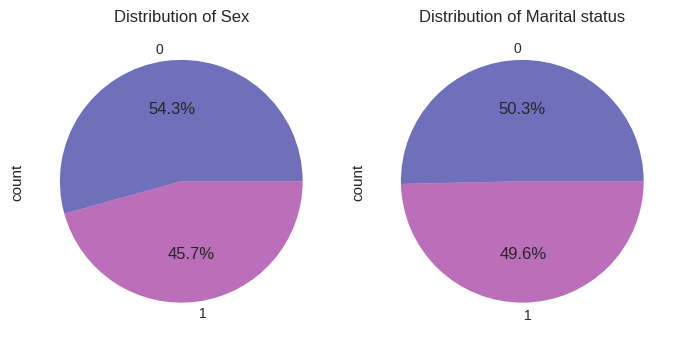

Men count 1086
Women count 914


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 5))
axes = axes.flatten()

for i, col in enumerate(df[["Sex", "Marital status"]]):
  df[col].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#00008890', '#88008890'], ax=axes[i])
  axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()
print(f"Men count {df['Sex'].value_counts()[0]}")
print(f"Women count {df['Sex'].value_counts()[1]}")

We get an equal distribution in marital status and almost equal in gender with a greater advantage on the male side.

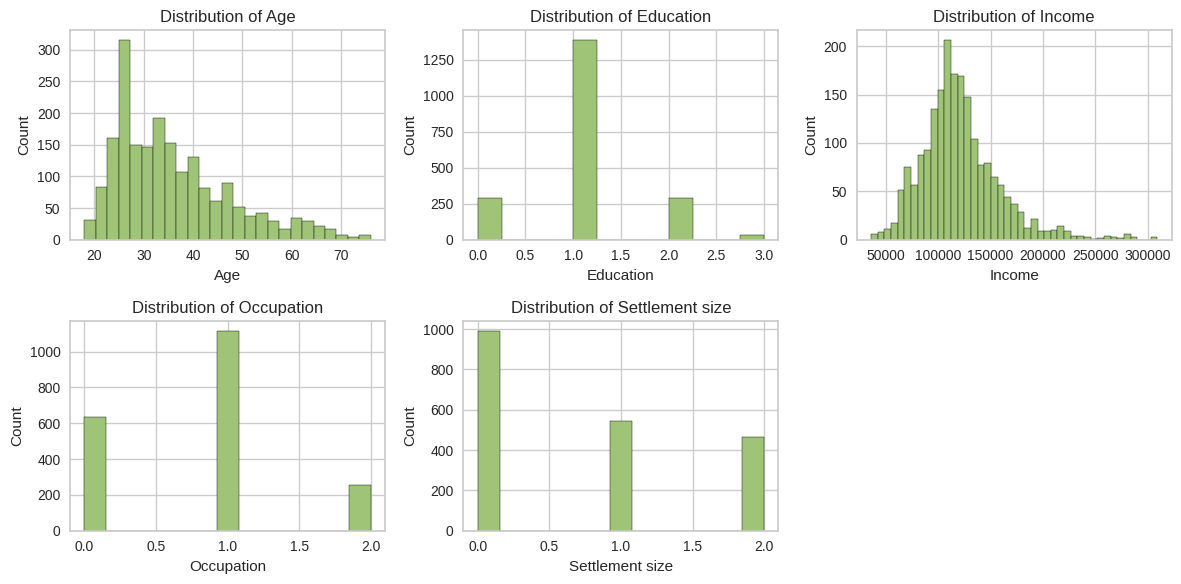

In [ ]:
coulmns = ["Age", "Education", "Income", "Occupation", "Settlement size"]
n_cols = 3
n_rows = (len(coulmns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))

axes = axes.flatten()

for i, col in enumerate(coulmns):
    sns.histplot(df[col], ax=axes[i], color='g', alpha=1)
    axes[i].set_title(f'Distribution of {col}')

for i in range(len(coulmns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Data processing

In [ ]:
df.drop('ID', axis=1, inplace=True)

In [ ]:
for col in df.columns:
    print(f'Unique values for {col}: {df[col].unique()}')


Unique values for Sex: [0 1]
Unique values for Marital status: [0 1]
Unique values for Age: [67 22 49 45 53 35 61 28 25 24 60 32 44 31 48 26 36 39 42 34 63 27 30 57
 33 37 58 23 29 52 50 46 51 41 40 66 47 56 54 20 21 38 70 65 74 68 43 55
 64 75 19 62 59 73 72 76 71 18]
Unique values for Education: [2 1 0 3]
Unique values for Income: [124670 150773  89210 ...  86400  97968  68416]
Unique values for Occupation: [1 0 2]
Unique values for Settlement size: [2 0 1]


In the dataset, the variables take numeric values, so there is no need for encoding

Some variables showed right skew in their distribution. Some models we will used in our clustering task assume that the data is normally distributed. One type of this model is KMeans. We will create a working copy of our dataset and perform transformations to bring the distribution closer to the normal distribution.

In [ ]:
X = df.copy()
powtr = PowerTransformer()
income_transf = powtr.fit_transform(X["Income"].to_numpy().reshape(-1, 1))
age_transf = np.log(X["Age"])

X["Income"] = income_transf
X["Age"] = age_transf


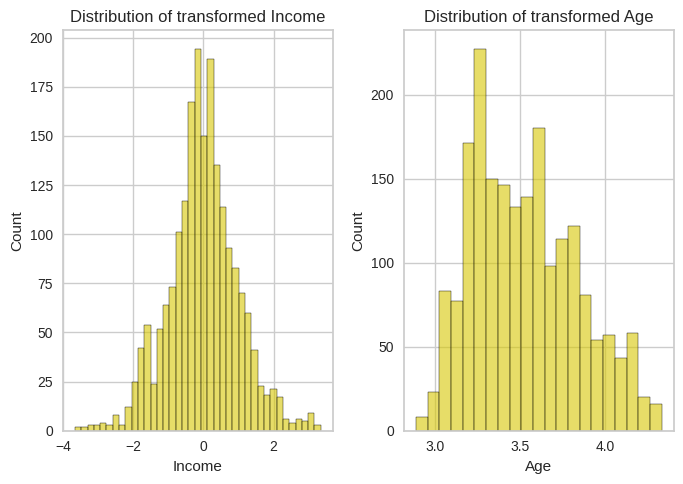

In [ ]:
n_cols = 2
n_rows = 1

fig, axes = plt.subplots(1, 2, figsize=(7, 5))

axes = axes.flatten()

for i, col in enumerate(["Income", "Age"]):
    sns.histplot(X[col], ax=axes[i], color='y', alpha=0.6)
    axes[i].set_title(f'Distribution of transformed {col}')

for i in range(len(["Income", "Age"]), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

As we can see, our transformations had the desired effect and the distribution of the variables is close to normal. In the case of the Age variable, this is not an ideal distribution, but it should be enough.

In [ ]:
X.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,4.204693,2,0.239545,1,2
1,1,1,3.091042,1,0.869781,1,2
2,0,0,3.891820,1,-0.846121,0,0
3,0,0,3.806662,1,1.303766,1,1
4,0,0,3.970292,1,0.830970,1,1


MinMaxScaler is a data preprocessing technique that scales the features of a dataset to a specific range, usually between 0 and 1. It does this by subtracting the minimum value of each feature and dividing by the range (max - min).

In clusterization, MinMaxScaler is important because it ensures that features with larger numerical ranges do not dominate the clustering process. Without scaling, features with larger values could disproportionately affect the distance calculations, leading to biased or incorrect cluster formation.

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X).head()

,0,1,2,3,4,5,6
0,0.0,0.0,0.912494,0.666667,0.556511,0.5,1.0
1,1.0,1.0,0.139320,0.333333,0.646532,0.5,1.0
2,0.0,0.0,0.695276,0.333333,0.401437,0.0,0.0
3,0.0,0.0,0.636153,0.333333,0.708521,0.5,0.5
4,0.0,0.0,0.749756,0.333333,0.640988,0.5,0.5


# Elbow method

The elbow method is a technique used to determine the optimal number of clusters in a dataset for k-means clustering. The method works by plotting the Within Cluster Sum of Squares between each data point and its assigned centroid. As K increases, the WCSS tends to decrease, since with more clusters, each data point is likely to be closer to its assigned centroid. A point where the rate of decrease sharply changes and levels off is called "elbow" and is considered the optimal number of clusters.

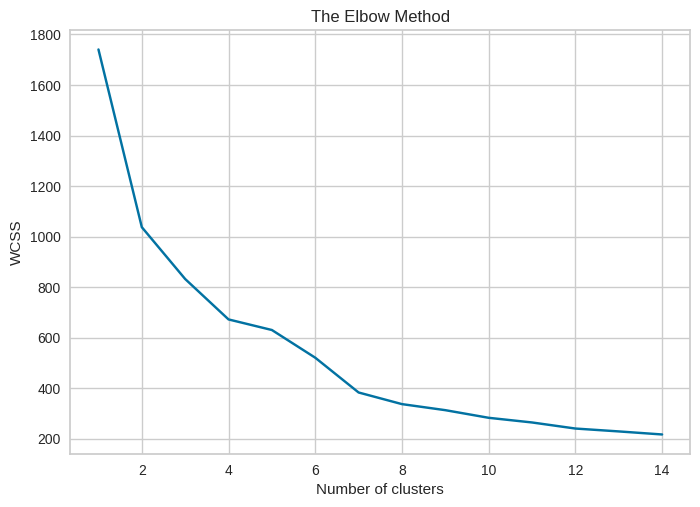

In [ ]:
wcss = []
for i in range (1, 15):
  kmeans = KMeans(n_clusters = i, init='k-means++', random_state = 42)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)
plt.plot(range(1,15), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


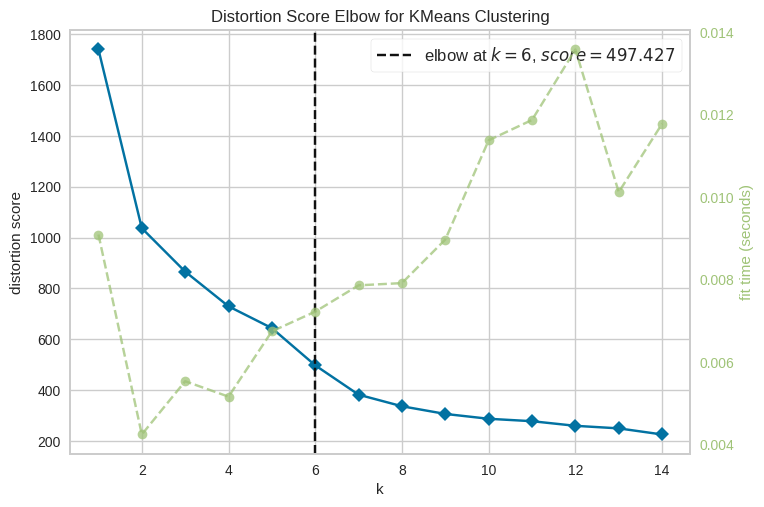

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
model = KMeans(random_state = 0)
visualizer = KElbowVisualizer(model, k=(1,15), timings=True)
visualizer.fit(X)
visualizer.show()

KElbowVisuarizer suggests using 6 clusters, and that's how many we will use for our task.

# Silhouette method

Average silhouette approach measures the quality of a clustering. That is, it determines how well each object lies within its cluster. A high average silhouette width indicates a good clustering. The optimal number of clusters k is the one that maximize the average silhouette over a range of possible values for k (Kaufman and Rousseeuw 1990).

In [ ]:

km = KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=100, random_state=42)
km.fit_predict(X)
labels = km.labels_
silhouette_score_kmeans = silhouette_score(X, labels, metric='euclidean')
print("Silhouette score:", silhouette_score_kmeans)

Silhouette score: 0.4274366097508154


The silhouette score falls within the range [-1, 1]. The silhouette score of 1 means that the clusters are very dense and nicely separated. The score of 0 means that clusters are overlapping. The score of less than 0 means that data belonging to clusters may be wrong/incorrect.



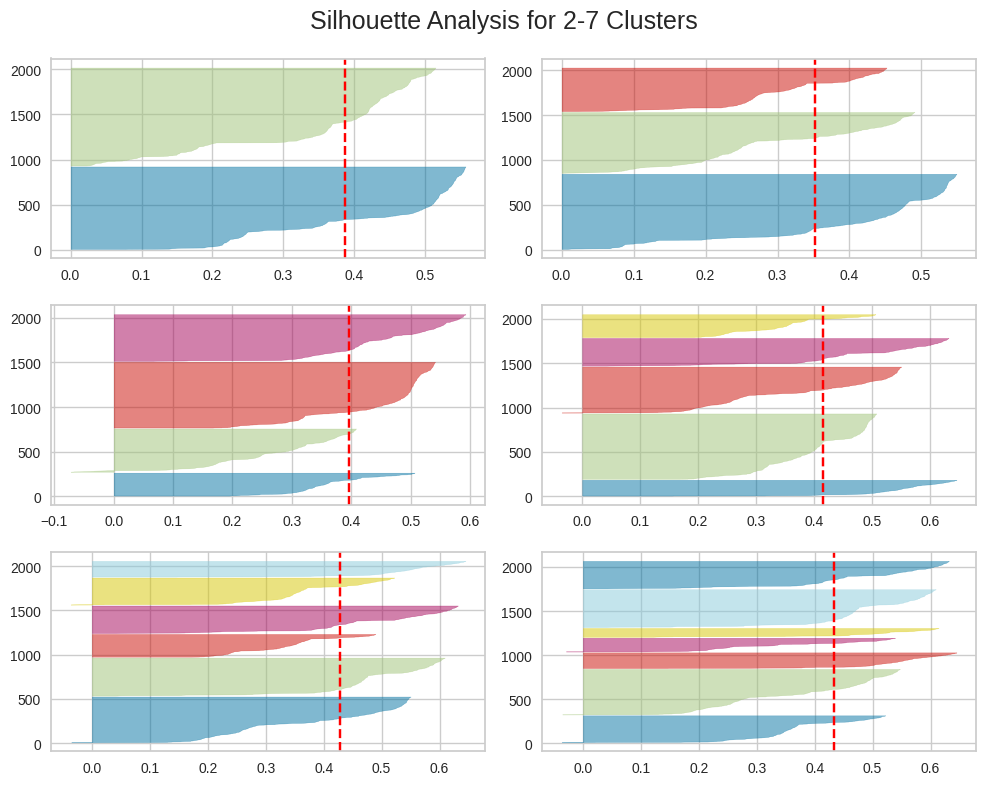

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(10,8))
fig.suptitle('Silhouette Analysis for 2-7 Clusters', size = 18)
plt.tight_layout()

for i in [2, 3, 4, 5, 6, 7]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)

We get the biggest result when using 6 clusters. This is the number we will use but the choice is not obvious, because with 7 clusters our result would be larger however we would get a larger difference in cluster sizes.

# K-Means

K-means is a unsupervised, centroid-based clustering algorithm. It assigns data points to one of the K clusters depending on their distance from the center of the clusters. It starts by randomly assigning the clusters centroid in the space. Then each data point assign to one of the cluster based on its distance from centroid of the cluster.

In [ ]:
kmeans = KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=100, random_state=42)
classlabels = kmeans.fit_predict(X)

df['Kmeans'] = classlabels
df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Kmeans
0,0,0,67,2,124670,1,2,0
1,1,1,22,1,150773,1,2,4
2,0,0,49,1,89210,0,0,3
3,0,0,45,1,171565,1,1,0
4,0,0,53,1,149031,1,1,0


We perform kmeans clustering and its results are stored in the original dataset.

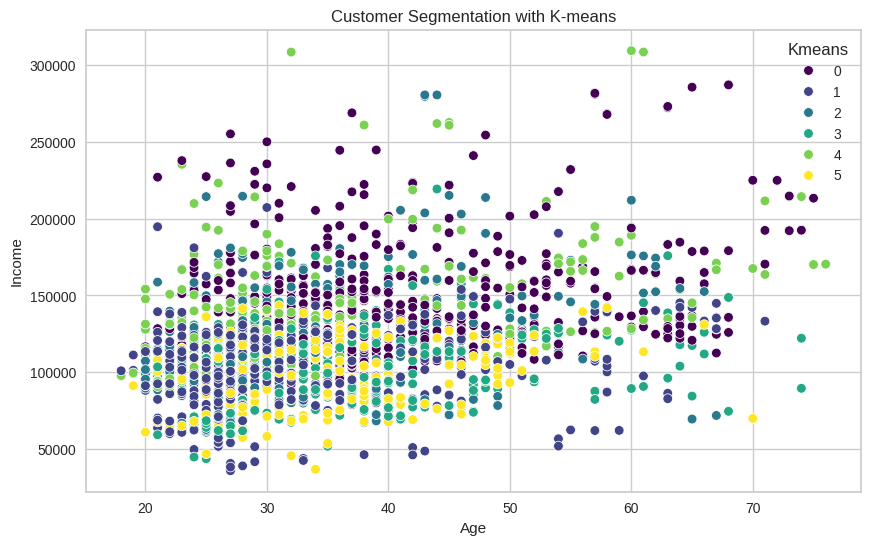

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Age'], y=df['Income'], hue=df['Kmeans'], data=df, palette='viridis')
plt.title('Customer Segmentation with K-means')
plt.xlabel('Age')
plt.ylabel('Income')
plt.show()

We can tell that this plot is bad but why? Scatterplot only shows two dimensions, but clustering happens in the full feature space. We can use technique like PCA (Principal Component Analysis) to reduce the multidimensional clustering into 2D for better visualization.

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca.head()

,PC1,PC2
0,-0.829143,0.350518
1,0.531854,0.719504
2,-0.489493,-0.693627
3,-0.712487,-0.027906
4,-0.718334,-0.036815


Now we have found a low dimensional subspace that maximises the variance of the data in that subspace and perform a linear projection.

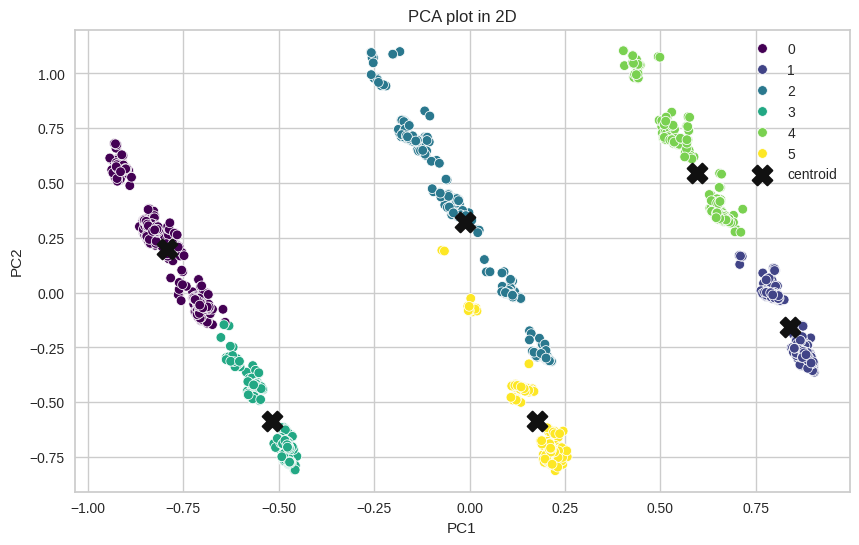

In [ ]:
kmeans = KMeans(n_clusters=6, n_init=15, max_iter=300, random_state=0)
clusters = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df['Kmeans'], data=df_pca, palette='viridis')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, linewidths=1.5, color='k', label='centroid')

plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# Hierarchical clustering

HCA is a method of cluster analysis that seeks to build a hierarchy of clusters. It's used to group objects in clusters based on how similar thay are to each other.

They are two types of hierarchical clustering:
* **Agglomerative** it starts with an individual element and then groups them into signle clusters.
* **Divisive** it starts with a complete dataset and divides it into portions.

It is less sensitive to outliers, can be adapted to incorporate categorical variables but is relatively slow, sensitive to scale and heavily driven bt heuristics.

Firstly, we determine the number of clusters using the silhouette method.
We use the **ward linkage**. It minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.

In [ ]:
scores = []

for n_clusters in range(2, 8):
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters,linkage='ward')
    labels = hierarchical.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

For n_clusters = 2, the average silhouette_score is : 0.37771431390295795
For n_clusters = 3, the average silhouette_score is : 0.34752402268085764
For n_clusters = 4, the average silhouette_score is : 0.3975363440499633
For n_clusters = 5, the average silhouette_score is : 0.41374396379557016
For n_clusters = 6, the average silhouette_score is : 0.392292972282248
For n_clusters = 7, the average silhouette_score is : 0.4033091143124254


Hierarchical approach works better with 5 clusters so we will proceed with this number.

In [ ]:
hierarchical = AgglomerativeClustering(n_clusters=5,linkage='ward')
labels = hierarchical.fit_predict(X)
df['Hierarchical_Clusters'] = labels

Again, after running the experiment, we save the results in the original dataframe.

We can visualize hierarchical clustering using **dendrogram**. A dendrogram in hierarchical clustering is a tree-like diagram that shows the arrangement of data points or clusters in a hierarchical structure.

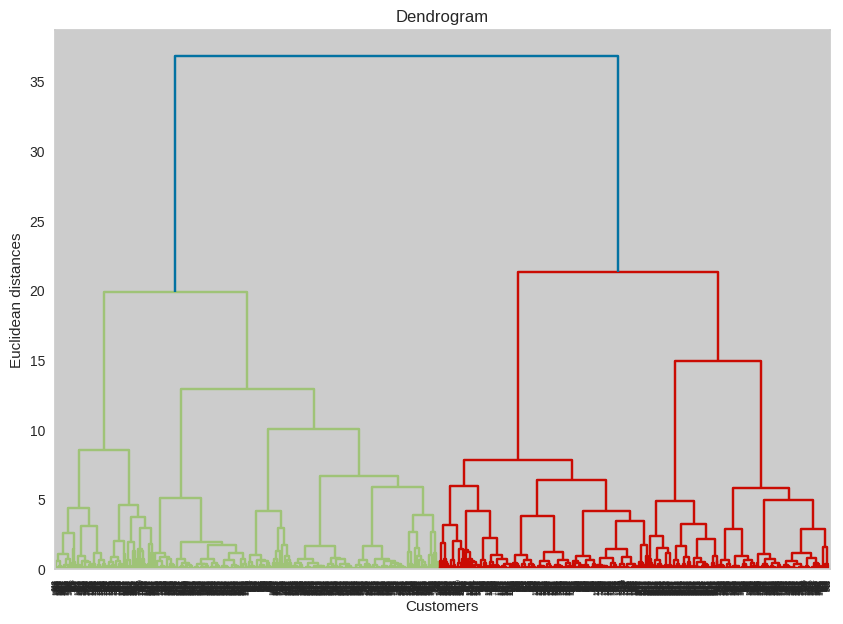

In [ ]:
plt.figure(figsize=(10, 7))
linkage_matrix = linkage(X, method='ward')
dendrogram = sch.dendrogram(linkage_matrix)
plt.title(f'Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

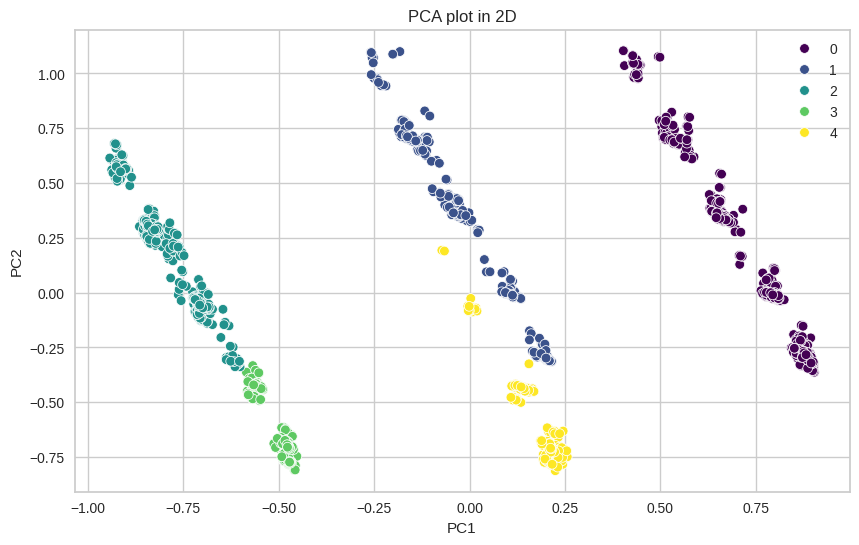

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df['Hierarchical_Clusters'], data=df_pca, palette='viridis')

plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

It is worth noting that in the case of Hierarchical Clustering there are no centroids.

# DBSCAN

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples).

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5) # eps is the maximum distance between two samples in one cluster
classlabels = dbscan.fit_predict(X)

df['DBSCAN'] = classlabels
df.head()


,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Kmeans,Hierarchical_Clusters,DBSCAN
0,0,0,67,2,124670,1,2,0,2,0
1,1,1,22,1,150773,1,2,4,0,1
2,0,0,49,1,89210,0,0,3,3,2
3,0,0,45,1,171565,1,1,0,2,3
4,0,0,53,1,149031,1,1,0,2,3


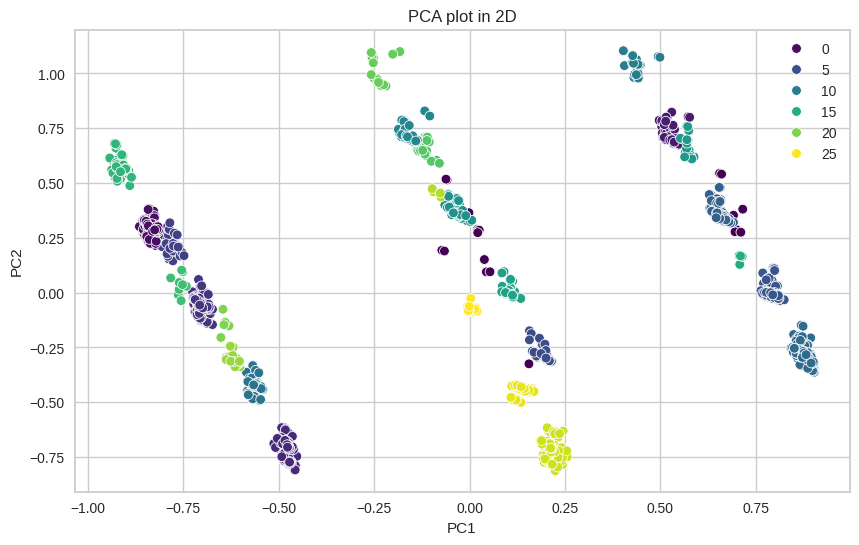

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df['DBSCAN'], data=df_pca, palette='viridis')

plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

Oured data has not been clustered in a satisfactory way. This may be due to the fact that DBSCAN is based on density and in our dataset the data is in high density groups.

# Models comparison

All the models used are unsupervised learning methods. We cannot, therefore, in their case apply measures such as “accuracy”, “precision”, “mse”, to compare the performance of each of them. Our main criterion will be the silhouette score and the visual representation of the clustering performed.

In [143]:
print(f"Silhouette score for K-means: {silhouette_score_kmeans}")
print(f"Silhouette score for Hierarchical clustering: {silhouette_score(X, labels, metric='euclidean')}")
print(f"Silhouette score for DBSCAN: {silhouette_score(X, classlabels, metric='euclidean')}")

Silhouette score for K-means: 0.4274366097508154
Silhouette score for Hierarchical clustering: 0.41374396379557016
Silhouette score for DBSCAN: 0.4464395981315109


Paradoxically, the highest silhouette score is obtained for DBSCAN, however, bearing in mind the visual representation of this algorithm, we have to conclude that K-Means did the best with the task.


In [195]:

def visualize_cluster_distributions(df, cluster_column):
  coulmns = ["Sex", "Marital status", "Education", "Occupation", "Settlement size"]
  n_cols = 3
  n_rows = 2

  fig, axes = plt.subplots(2, n_cols, figsize=(12,6))

  axes = axes.flatten()

  for i, col in enumerate(coulmns):
      sns.countplot(data=df, x=cluster_column, hue=col, ax=axes[i], palette='bright', alpha=1)
      axes[i].set_title(f'Distribution of {col} for {cluster_column}')


  for i in range(len(coulmns), len(axes)):
      fig.delaxes(axes[i])

  plt.tight_layout()
  plt.show()

  fig, axs = plt.subplots(figsize=(10, 6))
  sns.boxenplot(data=df, x=cluster_column, y=df["Age"], palette='pastel', order=["0", "1", "2", "3", "4", "5"])
  plt.hlines(y=df.Age.median(), xmin=0, xmax=5, colors="w", linestyles="dashed")
  axs.set_title("Age Distribution for each Cluster")
  plt.show()

  fig, axs = plt.subplots(figsize=(10, 6))
  sns.boxenplot(data=df, x=cluster_column, y=df["Income"], palette='pastel', order=["0", "1", "2", "3", "4", "5"])
  plt.hlines(y=df.Income.median(), xmin=0, xmax=5, colors="w", linestyles="dashed")
  axs.set_title("Income Distribution for each Cluster")
  plt.show()



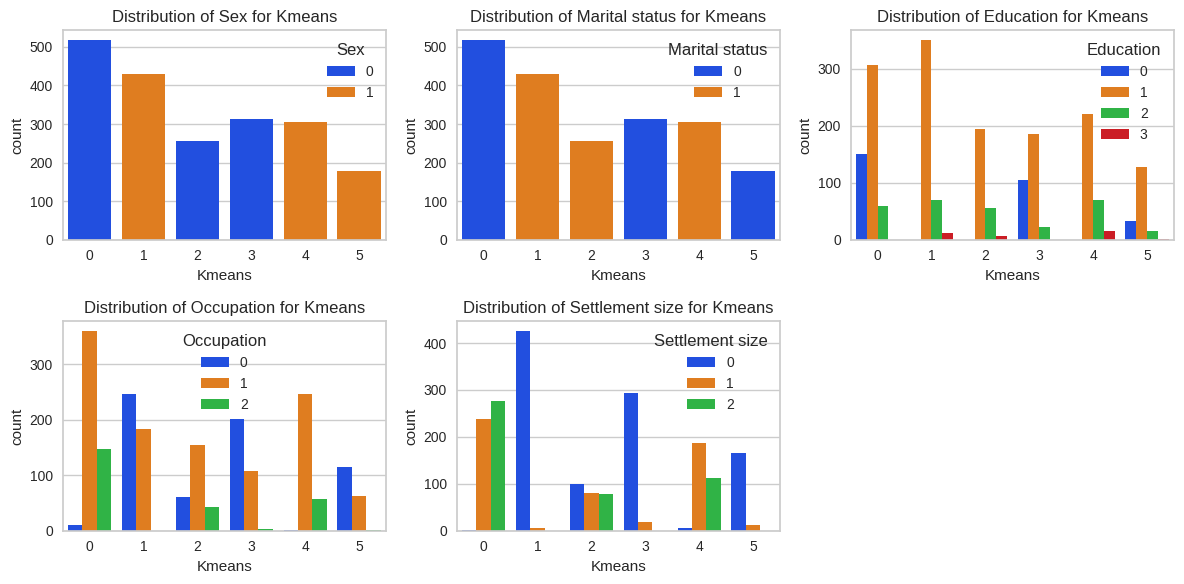

<ipython-input-195-a1fe768dd2f7>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df, x=cluster_column, y=df["Age"], palette='pastel', order=["0", "1", "2", "3", "4", "5"])


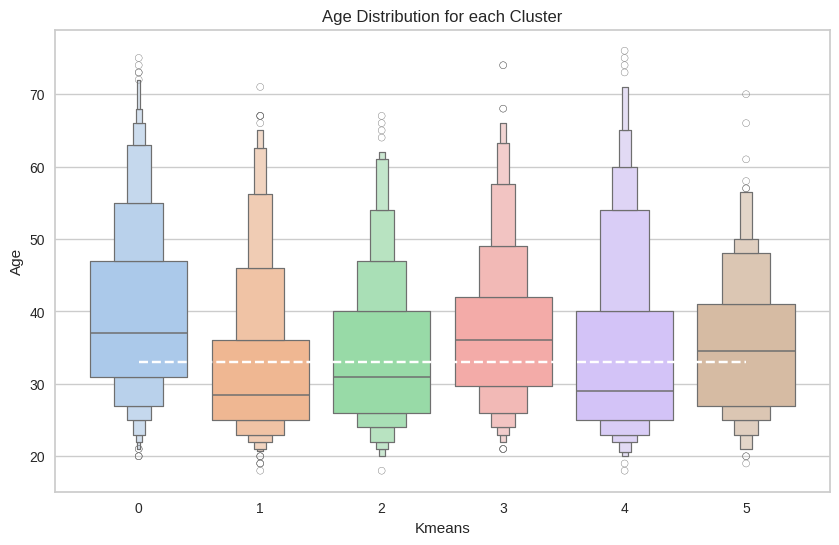

<ipython-input-195-a1fe768dd2f7>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df, x=cluster_column, y=df["Income"], palette='pastel', order=["0", "1", "2", "3", "4", "5"])


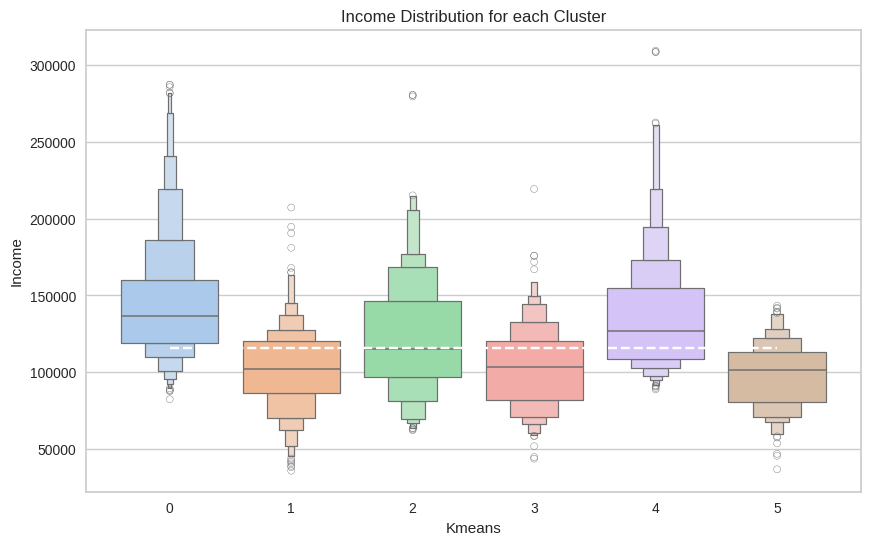

In [196]:

visualize_cluster_distributions(df, 'Kmeans')


**Cluster 0**:
*  Exclusively men
*  Exclusively single
*  Mostly high school education, highest percentage of unknown education
*  Highest tier ocupation
*  Big cities or medium-size cities
*  Oldest customers
*  Highest Income customer

**A wealthy, older man with a high-tier occupation, living in a big or medium-sized city, mostly with a high school education, and single.**

**Cluster 1**:
*  Exclusively women
*  Exclusively non-single
*  High education group
*  Mostly unemployed
*  Small cities
*  Youngest group
*  Smallest income

**A young, unemployed woman with high education, living in a small city, and married or in a relationship, with the lowest income.**

**Cluster 2**:
*  Exclusively men
*  Exclusively non-single
*  High education group
*  Mid tier occupation
*  Equal distribution among city type
*  Below Average age
*  Average Income

**A moderately educated, non-single man in a mid-tier occupation, living in a variety of city sizes, with an average income and below-average age.**

**Cluster 3**:
*  Exclusively men
*  Exclusively single
*  Low to medium tier education
*  Mostly unemployed
*  Mostly from small city
*  Old group
*  Second lowest income

**An older, single man with low to medium education, mostly unemployed, living in a small city, and earning a low income.**

**Cluster 4**:
*  Exclusively women
*  Exclusively non-single
*  Medium to high tier education
*  Medium to high tier occupation
*  Small or Big city
*  Second youngest group
*  Above average income

**A married or in a relationship woman with medium to high education, working in a mid to high-tier occupation, living in a small or big city, with above-average income and a relatively young age.**

**Cluster 5**:
*  Exclusively women
*  Exclusively single
*  Mostly high school education
*  Mostly unemployed
*  Small city
*  Above average age
*  Third lowest income

**An older, single woman with mostly high school education, unemployed, living in a small city, and earning a below-average income.**